This notebook was originally prepared for a seminar on practical statistics.

It was later re-adjusted in two ways:
 - original dataset was replaced with (similar) generated data
 - comments were added - like this one

In [1]:
import io

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.optimize
import scipy.stats as ss
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

# Data loading

We will work with a simple tabular dataset were each row records who (**email**) on what day (**day**) had to replace hard drives and on which machines (**hosts**).

In [2]:
CSV_CONTENT = """\
email,day,hosts\nadam@example.com,2023-07-03,hs13409\njohn@example.com,2023-08-25,hs16859\nlisa@example.com,2023-06-29,hs14439\nadam@example.com,2023-08-22,hs14853\njohn@example.com,2023-06-26,hs14486\njohn@example.com,2023-07-03,hs16720\njohn@example.com,2023-05-09,"hs15710,hs15259"\nadam@example.com,2023-06-21,hs16066\nadam@example.com,2023-07-25,"hs16256,hs15176"\nanna@example.com,2023-05-22,"hs14533,hs12691"\njohn@example.com,2023-06-07,hs12786\njake@example.com,2023-05-16,hs13470\nadam@example.com,2023-09-25,hs14800\njake@example.com,2023-09-06,hs16298\njohn@example.com,2023-05-22,hs13734\njohn@example.com,2023-06-14,hs12559\njohn@example.com,2023-09-05,hs12090\nanna@example.com,2023-09-11,hs12205\njake@example.com,2023-08-30,hs12392\nadam@example.com,2023-05-29,"hs13121,hs15785"\njake@example.com,2023-08-11,"hs15401,hs14866"\nadam@example.com,2023-08-16,hs13280\nadam@example.com,2023-05-22,hs15757\njohn@example.com,2023-05-18,"hs16566,hs15275,hs13918,hs13378"\njohn@example.com,2023-09-21,hs14026\njake@example.com,2023-07-07,hs14886\nadam@example.com,2023-06-30,hs15352\njake@example.com,2023-08-07,hs12794\nadam@example.com,2023-07-13,hs15256\njohn@example.com,2023-07-03,hs16866\njohn@example.com,2023-08-28,hs16723\njake@example.com,2023-09-04,hs12349\nadam@example.com,2023-06-28,hs15910\njohn@example.com,2023-08-21,hs14268\njake@example.com,2023-09-04,hs16454\nanna@example.com,2023-07-17,hs14604\nadam@example.com,2023-09-05,hs13672\njake@example.com,2023-07-06,hs12044\nlisa@example.com,2023-09-14,hs12584\nadam@example.com,2023-09-07,hs14246\njohn@example.com,2023-08-30,hs14967\njohn@example.com,2023-07-17,hs13348\nanna@example.com,2023-09-25,hs14854\nadam@example.com,2023-07-25,"hs12224,hs14160"\njake@example.com,2023-07-10,hs12743\njohn@example.com,2023-06-23,hs16544\njake@example.com,2023-05-12,hs15206\njohn@example.com,2023-09-04,hs15473\nanna@example.com,2023-05-24,hs14601\nadam@example.com,2023-10-09,hs14927\nadam@example.com,2023-06-01,"hs16710,hs15007,hs13253"\njohn@example.com,2023-09-04,hs16656\njohn@example.com,2023-06-05,"hs16908,hs14352,hs14722"\nlisa@example.com,2023-09-26,hs15540\nanna@example.com,2023-09-05,hs14108\nadam@example.com,2023-10-02,hs13153\njake@example.com,2023-05-22,"hs16663,hs14618,hs13935"\nlisa@example.com,2023-09-11,hs13156\nlisa@example.com,2023-09-14,hs12054\njohn@example.com,2023-05-15,"hs15892,hs16157"\nlisa@example.com,2023-07-18,hs16566\nadam@example.com,2023-06-05,hs12469\njohn@example.com,2023-10-04,hs14338\nadam@example.com,2023-07-19,"hs16717,hs13528"\njohn@example.com,2023-06-05,hs13487\njohn@example.com,2023-10-06,hs15086\njohn@example.com,2023-06-12,hs16930\nadam@example.com,2023-06-30,"hs16087,hs16907"\njohn@example.com,2023-09-04,hs16694\njake@example.com,2023-05-29,hs16773\nadam@example.com,2023-05-26,"hs12841,hs15411,hs13132,hs12448"\nadam@example.com,2023-09-22,hs13686\ntony@example.com,2023-05-22,"hs16995,hs14539,hs15628"\njake@example.com,2023-06-12,hs12313\nadam@example.com,2023-05-29,"hs16235,hs13535,hs16856,hs13941,hs14086,hs15757,hs15600,hs13969"\nadam@example.com,2023-05-18,"hs16743,hs16339"\ntony@example.com,2023-08-21,hs12207\nadam@example.com,2023-07-24,"hs15458,hs16944"\njohn@example.com,2023-05-11,"hs13809,hs13052,hs13110,hs12222"\njohn@example.com,2023-05-22,"hs12176,hs15374,hs13856,hs16823,hs12977"\nlisa@example.com,2023-09-25,hs12273\nanna@example.com,2023-05-11,"hs13646,hs13788,hs12930,hs14199"\njohn@example.com,2023-09-18,hs16921\nadam@example.com,2023-07-04,hs12095\njohn@example.com,2023-08-09,hs12097\nanna@example.com,2023-09-01,"hs15572,hs14508"\nanna@example.com,2023-09-11,hs14235\nanna@example.com,2023-08-10,hs13478\njohn@example.com,2023-07-24,"hs14299,hs14789"\nanna@example.com,2023-09-18,hs13585\n
"""
RAW_DATA = pd.read_csv(io.StringIO(CSV_CONTENT), parse_dates=['day'])
RAW_DATA

,email,day,hosts
0,adam@example.com,2023-07-03,hs13409
1,john@example.com,2023-08-25,hs16859
2,lisa@example.com,2023-06-29,hs14439
3,adam@example.com,2023-08-22,hs14853
4,john@example.com,2023-06-26,hs14486
...,...,...,...
85,anna@example.com,2023-09-01,"hs15572,hs14508"
86,anna@example.com,2023-09-11,hs14235
87,anna@example.com,2023-08-10,hs13478
88,john@example.com,2023-07-24,"hs14299,hs14789"


A few additional columns will be later useful for analysis.

In [3]:
DATA = (
    RAW_DATA
    .assign(
        hosts=lambda df: df['hosts'].str.split(',').map(tuple),
        host_count=lambda df: df.hosts.map(len),
        week=lambda df: (df.day - df.day.min()) // pd.Timedelta(7, 'days'),
        dow=lambda df: df.day.dt.day_name(),
    )
)
DATA

,email,day,hosts,host_count,week,dow
0,adam@example.com,2023-07-03,"(hs13409,)",1,7,Monday
1,john@example.com,2023-08-25,"(hs16859,)",1,15,Friday
2,lisa@example.com,2023-06-29,"(hs14439,)",1,7,Thursday
3,adam@example.com,2023-08-22,"(hs14853,)",1,15,Tuesday
4,john@example.com,2023-06-26,"(hs14486,)",1,6,Monday
...,...,...,...,...,...,...
85,anna@example.com,2023-09-01,"(hs15572, hs14508)",2,16,Friday
86,anna@example.com,2023-09-11,"(hs14235,)",1,17,Monday
87,anna@example.com,2023-08-10,"(hs13478,)",1,13,Thursday
88,john@example.com,2023-07-24,"(hs14299, hs14789)",2,10,Monday


# Confidence intervals

Goal: a confidence interval for the average number of hosts having disks replaced every week.

In [4]:
CONFIDENCE = .999

HOST_COUNT_BY_WEEK = (
    pd.Series(range(DATA.week.min(), DATA.week.max()))  # dropping the last, incomplete week
    .map(DATA.groupby('week').host_count.sum())
    .fillna(0).astype(int)
    .rename('host_count')
)
HOST_COUNT_BY_WEEK.index.name = 'week'
display(HOST_COUNT_BY_WEEK.to_frame().head())
HOST_COUNT_BY_WEEK.shape

,host_count
week,
0,13
1,22
2,16
3,8
4,3


(21,)

In [5]:
HOST_COUNT_BY_WEEK.describe(percentiles=((1 - CONFIDENCE) / 2, 1 - (1 - CONFIDENCE) / 2))

count     21.000000
mean       6.238095
std        5.262174
min        1.000000
0.05%      1.000000
50%        4.000000
99.95%    21.940000
max       22.000000
Name: host_count, dtype: float64

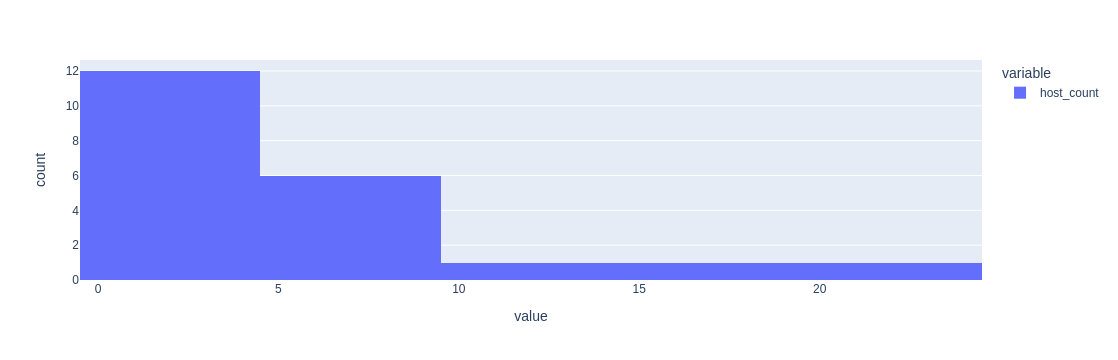

In [6]:
px.histogram(HOST_COUNT_BY_WEEK)

In [7]:
CONFIDENCE_INTERVALS = {}

## Method 1: Assuming a specific distribution

* specific to the distribution
* specific to the statistic
* the best possible result if the assumption is correct

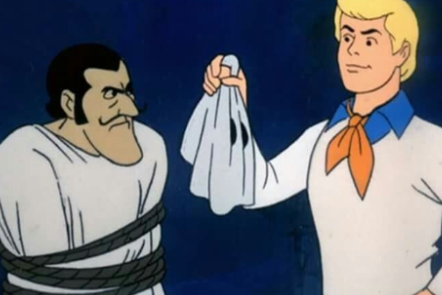

In [8]:
POISSON = ss.poisson(HOST_COUNT_BY_WEEK.mean())

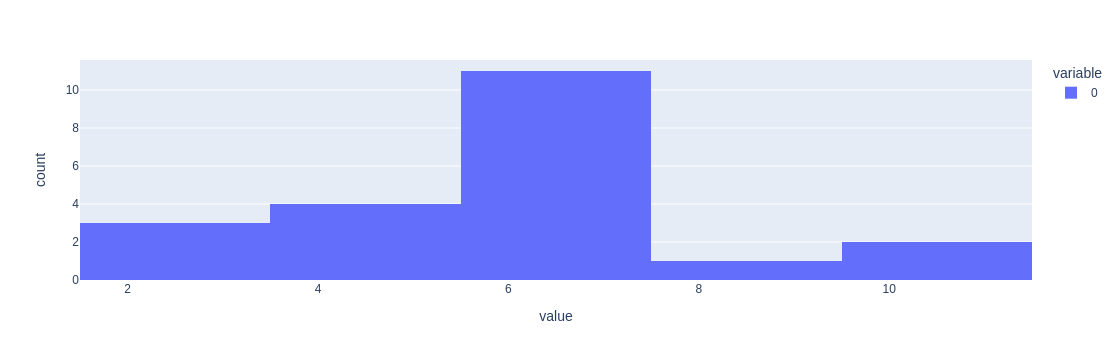

In [9]:
px.histogram(POISSON.rvs(HOST_COUNT_BY_WEEK.shape))

In [10]:
def poisson_ci_for_mean(sample, confidence):
    n = len(sample)
    total = sum(sample)
    alpha = (1 - confidence) / 2
    low = scipy.optimize.bisect(
        lambda rate: ss.poisson(rate * n).cdf(total - 1) - (1 - alpha),
        0, max(sample),
    )
    high = scipy.optimize.bisect(
        lambda rate: ss.poisson(rate * n).cdf(total) - alpha,
        0, max(sample),
    )
    return low, high

CONFIDENCE_INTERVALS['poisson'] = poisson_ci_for_mean(HOST_COUNT_BY_WEEK, CONFIDENCE)
CONFIDENCE_INTERVALS

{'poisson': (4.599019673897033, 8.243234025016704)}

## Method 2: Approximating with the normal distribution aka using the Central Limit Theorem

* **not** specific to the distribution
* works for a specific statistic (**mean**)
* should work well if the sample size is sufficiently close to infinity 😉
* confidence  intervals are always symmetrical around the mean

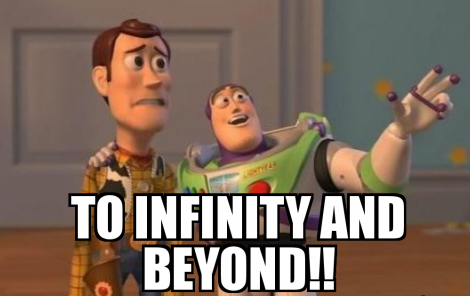

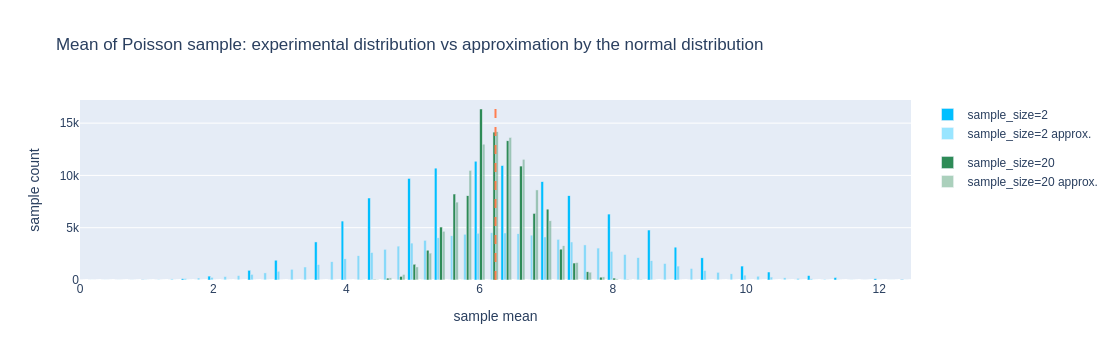

In [11]:
fig = go.Figure()
fig.add_vline(x=HOST_COUNT_BY_WEEK.mean(), line_dash="dash", line_color="coral")

step = 0.2
bins = np.arange(0 - step / 2, 2 * HOST_COUNT_BY_WEEK.mean() + step / 2, step)
bin_start = bins[:-1]
bin_end = bins[1:]
mean_count = 100000

for sample_size, color in zip([2, 20], ['deepskyblue', 'seagreen']):
    fig.add_trace(go.Bar(
        x=(bin_start + bin_end) / 2,
        y=np.histogram(POISSON.rvs((mean_count, sample_size)).mean(1), bins)[0],
        name=f'sample_size={sample_size}',
        legendgroup=f'sample_size={sample_size}',
        marker_color=color,
    ))
    norm = ss.norm(loc=POISSON.mean(), scale=POISSON.std() / np.sqrt(sample_size))
    fig.add_trace(go.Bar(
        x=(bin_start + bin_end) / 2,
        y=(norm.cdf(bin_end) - norm.cdf(bin_start)) * mean_count,
        name=f'sample_size={sample_size} approx.',
        legendgroup=f'sample_size={sample_size}',
        marker_color=color,
        opacity=0.4,
    ))
fig.update_layout(
    title='Mean of Poisson sample: experimental distribution vs approximation by the normal distribution',
    xaxis_range=[0, 2 * HOST_COUNT_BY_WEEK.mean()],
    xaxis_title='sample mean',
    yaxis_title='sample count')
fig

In [12]:
def large_sample_ci_for_mean(sample, confidence):
    mean = sample.mean()
    n = len(sample)
    std = sample.std()
    t = ss.t(df=n - 1).ppf(1 - (1 - confidence) / 2)
    radius = t * (std / np.sqrt(n))
    return mean - radius, mean + radius


CONFIDENCE_INTERVALS['large_sample'] = large_sample_ci_for_mean(HOST_COUNT_BY_WEEK, CONFIDENCE)
CONFIDENCE_INTERVALS

{'poisson': (4.599019673897033, 8.243234025016704),
 'large_sample': (1.8176936664277976, 10.658496809762678)}

## Method 3: bootstrap

* **not** specific to the distribution
* **not** specific to the statistic
* should work well if the value space is reasonably covered by the samples

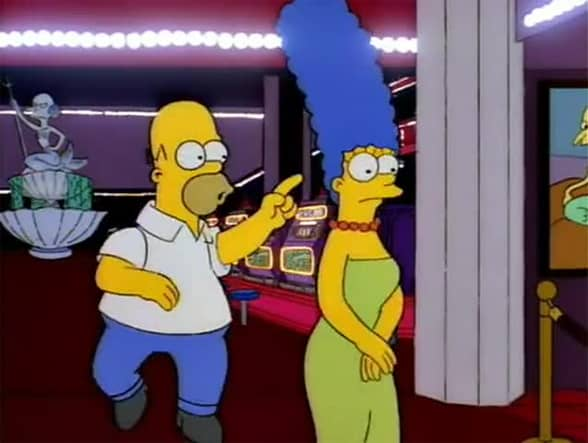

In [13]:
def bootstrap_ci(sample, statistic, confidence):
    ci = ss.bootstrap(
        sample.to_numpy()[np.newaxis, :],
        statistic=statistic,
        confidence_level=confidence,
    ).confidence_interval
    return ci.low, ci.high

CONFIDENCE_INTERVALS['bootstrap'] = bootstrap_ci(HOST_COUNT_BY_WEEK, np.mean, CONFIDENCE)
CONFIDENCE_INTERVALS

{'poisson': (4.599019673897033, 8.243234025016704),
 'large_sample': (1.8176936664277976, 10.658496809762678),
 'bootstrap': (3.7142857142857144, 11.076459579219815)}

Works for statistics other than the mean!

In [14]:
bootstrap_ci(
    HOST_COUNT_BY_WEEK,
    statistic=lambda a, axis: np.quantile(a, 0.99, axis),
    confidence=0.95,
)

(14.600000000000005, 22.0)

## Summary

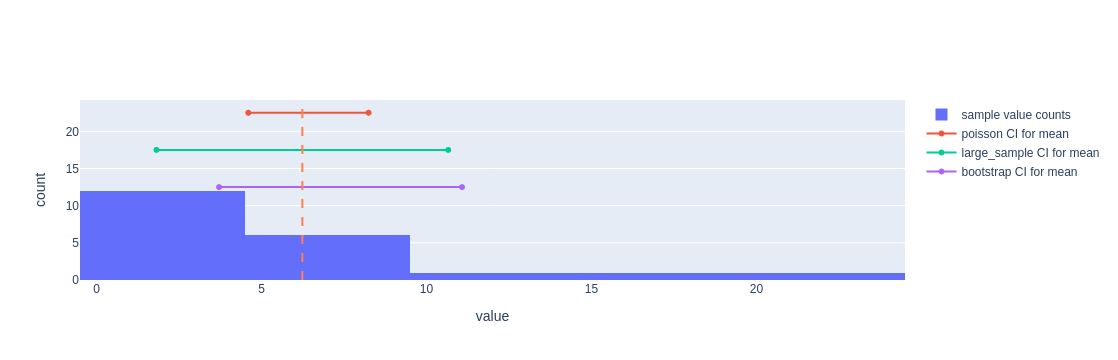

In [15]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=HOST_COUNT_BY_WEEK, name='sample value counts'))
fig.add_vline(x=HOST_COUNT_BY_WEEK.mean(), line_dash="dash", line_color="coral")
for ix, (name, (low, high)) in enumerate(CONFIDENCE_INTERVALS.items()):
    fig.add_trace(go.Scatter(x=[low, high], y=2 * [22.5 - ix * 5], name=f'{name} CI for mean'))
fig.update_layout(xaxis_title_text="value", yaxis_title_text="count")
fig

# Basic hypothesis testing

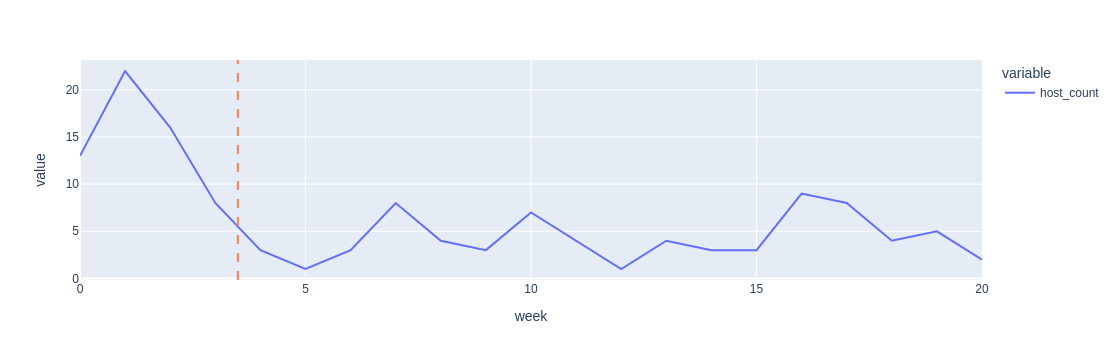

In [16]:
px.line(HOST_COUNT_BY_WEEK).add_vline(x=3.5, line_dash="dash", line_color="coral")

In [17]:
SPLIT = np.where(HOST_COUNT_BY_WEEK.index <= 3, 'before', 'after')
HOST_COUNT_BY_WEEK.groupby(SPLIT).describe().loc[['before', 'after']]

,count,mean,std,min,25%,50%,75%,max
before,4.0,14.750000,5.852350,8.0,11.75,14.5,17.5,22.0
after,17.0,4.235294,2.411675,1.0,3.00,4.0,5.0,9.0


## Hypothesis
$X_{before}$ - random variable for the number of hosts with disks replaced in a week before week 30

$X_{after}$ - random variable for the number of hosts with disks replaced in a week after week 30

**Hypothesis** $H_1$: $E(X_{before}) > E(X_{after})$

**Null hypothesis** $H_0$: $E(X_{before}) \leq E(X_{after})$. Actually, $E(X_{before}) = E(X_{after})$.

**Goal:** Verify the hypothesis by computing the **p-value**, ie. the probability of the observations under $H_0$.

We will reject $H_0$ if the p-value is below 5%.

## Method 1: Assuming a specific distribution

* specific to the distribution
* specific to the statistic
* the best possible result if the assumption is correct

nope, too much work

## Method 2: Approximating with the normal distribution aka using the Central Limit Theorem

* **not** specific to the distribution
* works for a specific statistic (**mean**)
* should work well if the sample sizes are sufficiently close to infinity 😉
* you need to consider the two variances: are they known? same or different?

meh, too much work

## Method 3: bootstrap

* **not** specific to the distribution
* **not** specific to the statistic
* should work well if the value space is reasonably covered by the samples

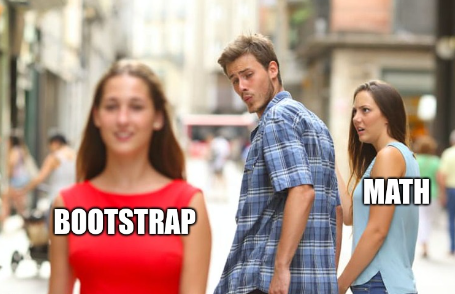

In [18]:
def resample_and_apply(samples, size, statistic, n_resamples=9999):
    resampled = np.random.choice(samples, (n_resamples, size))
    return np.apply_over_axes(statistic, resampled, [1])

def bootstrap_hypothesis_pvalue(samples_low, samples_high, statistic):
    distance = statistic(samples_high) - statistic(samples_low)
    assert distance > 0
    samples = np.concatenate((samples_low, samples_high))
    resampled_stats_high = resample_and_apply(samples, len(samples_high), statistic)
    resampled_stats_low = resample_and_apply(samples, len(samples_low), statistic)
    return np.mean((resampled_stats_high - resampled_stats_low) >= distance)

bootstrap_hypothesis_pvalue(
    samples_low=HOST_COUNT_BY_WEEK[SPLIT == 'after'],
    samples_high=HOST_COUNT_BY_WEEK[SPLIT == 'before'],
    statistic=np.mean,
)

0.0012001200120012002

We can reject the null hypothesis.

# $\chi^2$ tests

## Homogeneity

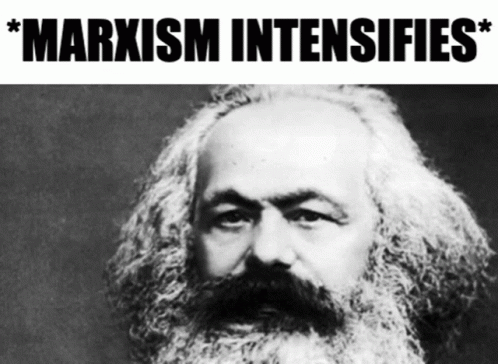

In [19]:
HOST_COUNT_BY_DOW = (
    DATA
    .groupby('dow').host_count.sum()
    .loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
)
HOST_COUNT_BY_DOW.to_frame()

,host_count
dow,
Monday,65
Tuesday,14
Wednesday,13
Thursday,25
Friday,17


We can use the $\chi^2$ test to check against the null hypothesis that values are distributed homogenously.

In [20]:
ss.chisquare(HOST_COUNT_BY_DOW)

Power_divergenceResult(statistic=71.3731343283582, pvalue=1.1642007597770193e-14)

Low p-value! Null hypothesis rejected! Not homogenous!

## Specific expectations

> **Bob** *Monday makes up for the weekend, Tuesday to Friday is the same*

> **Alice** *No way! Wednesday has 13 and Thursday has 25!*

> **Bob**

In [21]:
ss.chisquare(
    f_obs=HOST_COUNT_BY_DOW,
    f_exp=np.array([3, 1, 1, 1, 1]) / 7 * sum(HOST_COUNT_BY_DOW),
)

Power_divergenceResult(statistic=6.383084577114429, pvalue=0.17230768493375284)

> **Alice** 😞

## Independence

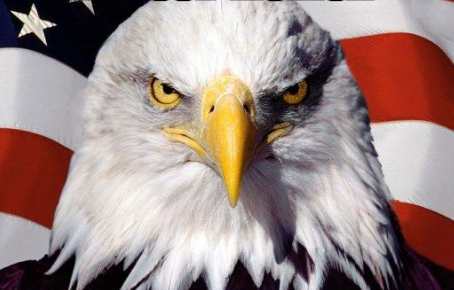

In [22]:
HOST_COUNT_BY_EMAIL_DOW = (
    DATA.groupby(['email', 'dow']).host_count.sum()
    .reset_index().pivot(index='email', columns='dow', values='host_count')
    .fillna(0).astype(int)
    [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
)
HOST_COUNT_BY_EMAIL_DOW

dow,Monday,Tuesday,Wednesday,Thursday,Friday
email,,,,,
adam@example.com,18,7,5,7,8
anna@example.com,7,1,1,5,2
jake@example.com,9,1,2,1,4
john@example.com,25,3,5,9,3
lisa@example.com,2,2,0,3,0
tony@example.com,4,0,0,0,0


We can use the $\chi^2$ test to check against the null hypothesis that values vary independently with the two axes.

In [23]:
'''
    Returns
    -------
    chi2 : float
        The test statistic.
    p : float
        The p-value of the test
    dof : int
        Degrees of freedom
    expected : ndarray, same shape as `observed`
        The expected frequencies, based on the marginal sums of the table.
'''
ss.chi2_contingency(HOST_COUNT_BY_EMAIL_DOW)

Chi2ContingencyResult(statistic=21.767882723225032, pvalue=0.35323764779003464, dof=20, expected_freq=array([[21.82835821,  4.70149254,  4.36567164,  8.39552239,  5.70895522],
       [ 7.76119403,  1.67164179,  1.55223881,  2.98507463,  2.02985075],
       [ 8.24626866,  1.7761194 ,  1.64925373,  3.17164179,  2.15671642],
       [21.82835821,  4.70149254,  4.36567164,  8.39552239,  5.70895522],
       [ 3.39552239,  0.73134328,  0.67910448,  1.30597015,  0.8880597 ],
       [ 1.94029851,  0.41791045,  0.3880597 ,  0.74626866,  0.50746269]]))

High p-value! Null hypothesis cannot be rejected! Day of week and email seem to be independent.

## Independence with specific marginals

> **Bob** *Monday makes up for the weekend, Tuesday to Friday is the same **and** email is independent*

> **Alice** *No way! How do you even test against that?*

> **Bob** *Hold my* 🍺

In [24]:
def marginal_distribution(a, axis):
    a = np.array(a)
    other_axes = sorted(set(range(a.ndim)) - {axis})
    return np.apply_over_axes(np.sum, a, other_axes) / a.sum(axis=None)


def custom_chi2_contingency(a, expected_marginals):
    a = np.array(a)
    assert a.ndim == len(expected_marginals) == 2  # KISS
    expected = expected_marginals[0] @ expected_marginals[1] * np.sum(a)
    return ss.chisquare(f_obs=a, f_exp=expected, axis=None, ddof=sum(a.shape) - a.ndim), expected


custom_chi2_contingency(
    HOST_COUNT_BY_EMAIL_DOW,
    expected_marginals=[
        marginal_distribution(HOST_COUNT_BY_EMAIL_DOW, 0),
        marginal_distribution(HOST_COUNT_BY_EMAIL_DOW, 1),
    ]
)

(Power_divergenceResult(statistic=21.767882723225036, pvalue=0.3532376477900344),
 array([[21.82835821,  4.70149254,  4.36567164,  8.39552239,  5.70895522],
        [ 7.76119403,  1.67164179,  1.55223881,  2.98507463,  2.02985075],
        [ 8.24626866,  1.7761194 ,  1.64925373,  3.17164179,  2.15671642],
        [21.82835821,  4.70149254,  4.36567164,  8.39552239,  5.70895522],
        [ 3.39552239,  0.73134328,  0.67910448,  1.30597015,  0.8880597 ],
        [ 1.94029851,  0.41791045,  0.3880597 ,  0.74626866,  0.50746269]]))

In [25]:
custom_chi2_contingency(
    HOST_COUNT_BY_EMAIL_DOW,
    expected_marginals=[
        marginal_distribution(HOST_COUNT_BY_EMAIL_DOW, 0),
        (np.array([3, 1, 1, 1, 1]) / 7).reshape(1, -1),
    ]
)

(Power_divergenceResult(statistic=28.13665577342049, pvalue=0.10620370706546724),
 array([[19.28571429,  6.42857143,  6.42857143,  6.42857143,  6.42857143],
        [ 6.85714286,  2.28571429,  2.28571429,  2.28571429,  2.28571429],
        [ 7.28571429,  2.42857143,  2.42857143,  2.42857143,  2.42857143],
        [19.28571429,  6.42857143,  6.42857143,  6.42857143,  6.42857143],
        [ 3.        ,  1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.71428571,  0.57142857,  0.57142857,  0.57142857,  0.57142857]]))

High p-value! Null hypothesis cannot be rejected!

It seems possible that Monday makes up for the weekend, Tuesday to Friday is the same **and** email is independent.

**Bob** impresses **Alice**. She cannot resist these stats skills. They live happily ever after.

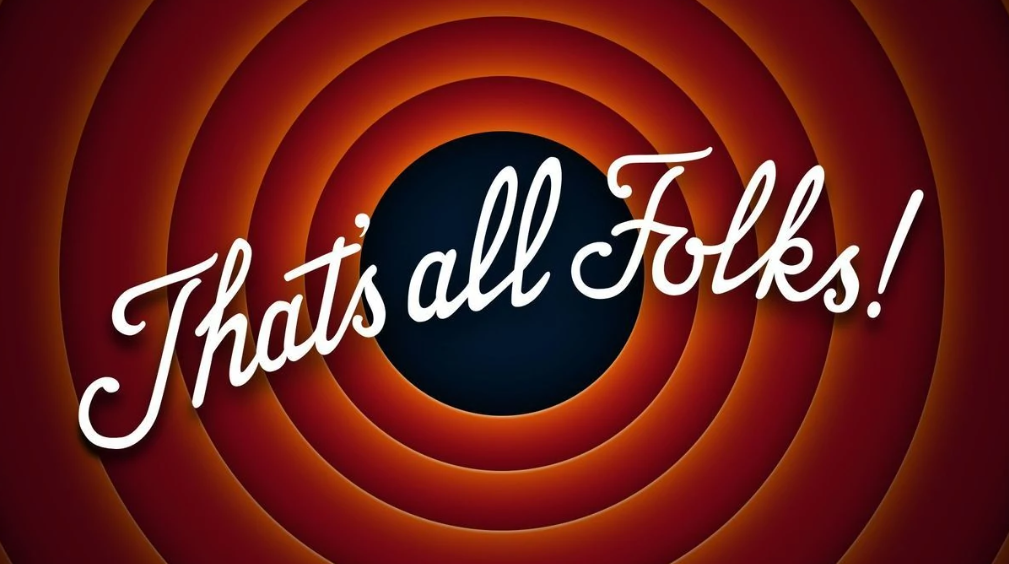